In [1]:
pip install rdflib SPARQLWrapper pandas tqdm requests

Note: you may need to restart the kernel to use updated packages.


In [2]:
import zipfile, json, pandas as pd, pathlib

zipfile.ZipFile("data.json.zip").extractall("data")  # Unzip the "data.json.zip" file into the "data" folder.

json_path = pathlib.Path("data/data.json")

with json_path.open(encoding="utf-8") as f:
    obj = json.load(f)
    
raw = obj["data"] if isinstance(obj, dict) else obj  # Check if it is dictionary or list
print(f"{len(raw)} records in total")

df = pd.json_normalize(raw)
df.head()

68076 records in total


,id,accession_number,share_license_status,tombstone,current_location,title,title_in_original_language,series,series_in_original_language,creation_date,...,dimensions.chain.height,dimensions.overall as mounted (both pieces).height,dimensions.overall as mounted (both pieces).width,dimensions.sheet (irregular).height,dimensions.sheet (irregular).width,dimensions.portfolio box.height,dimensions.portfolio box.width,dimensions.portfolio box.depth,dimensions.with mounting.height,dimensions.with mounting.width
0,74228,2020.113,CC0,"Fishmarket, 1902. Camille Pissarro (French, 18...",None,Fishmarket,None,None,None,1902,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,74539,2015.449,CC0,"A Miller's Carriage, c. 1895. Albert-Charles L...",None,A Miller's Carriage,None,None,None,c. 1895,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,74540,2015.451,CC0,"Leda and the Swan, c. 1846–83. Adolphe Yvon (F...",None,Leda and the Swan,None,None,None,c. 1846–83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,74551,2018.1059,CC0,"The Monks, c. 1802–30. François Marius Granet ...",None,The Monks,None,None,None,c. 1802–30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,74553,2018.1060,CC0,"Study Sheet, c. 1870–80. Alfred Dehodencq (Fre...",None,Study Sheet,None,None,None,c. 1870–80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
print("total columns: ", len(df.columns))
df.columns.tolist()  # Preview the columns and output as list

total columns:  954


['id',
 'accession_number',
 'share_license_status',
 'tombstone',
 'current_location',
 'title',
 'title_in_original_language',
 'series',
 'series_in_original_language',
 'creation_date',
 'creation_date_earliest',
 'creation_date_latest',
 'artists_tags',
 'culture',
 'technique',
 'support_materials',
 'department',
 'collection',
 'type',
 'measurements',
 'state_of_the_work',
 'edition_of_the_work',
 'copyright',
 'inscriptions',
 'provenance',
 'find_spot',
 'related_works',
 'former_accession_numbers',
 'did_you_know',
 'description',
 'citations',
 'catalogue_raisonne',
 'url',
 'alternate_images',
 'creditline',
 'sketchfab_id',
 'sketchfab_url',
 'gallery_donor_text',
 'creators',
 'updated_at',
 'dimensions.unframed.height',
 'dimensions.unframed.width',
 'dimensions.framed.height',
 'dimensions.framed.width',
 'dimensions.framed.depth',
 'exhibitions.current',
 'exhibitions.legacy',
 'external_resources.wikidata',
 'external_resources.internet_archive',
 'images.annotation

In [4]:
from __future__ import annotations
from typing import List, Dict
import re, time, requests, pprint
from rdflib import Graph, Namespace, URIRef, Literal
from rdflib.namespace import RDF, RDFS, DC, FOAF, OWL
from SPARQLWrapper import SPARQLWrapper, JSON

EX = Namespace("http://example.org/cma/")
WDQS = "https://query.wikidata.org/sparql"
UA = ("ACTH25-project/0.1 "
      "(https://github.com/yfgann/ACTH25_project; "
      "mailto:annyufeiguo@gmail.com)")

class Artifact:
    
    BASE = "https://openaccess-api.clevelandart.org/api/artworks"
    
    def __init__(self, rec: Dict):
        self.raw = rec
        self.id = rec["id"]
        self.title = rec.get("title", "no title")
        
        # For simplicity, only read the description of the first creator when there are multiple creators
        creators = rec.get("creators") or []
        if creators:
            self.creator = creators[0].get("description", "unknown artist")
        else:
            self.creator = "unknown artist" # If the list is empty, the art object is from unknown creator, output "unknown artist".
        
        # exact creation date or timeframe
        cdate = rec.get("creation_date")
        if cdate and isinstance(cdate, str) and cdate.strip():
            self.date_text = cdate.strip()
        else:
            earl = rec.get("creation_date_earliest")
            late = rec.get("creation_date_latest")
            if earl is not None and late is not None:
                self.date_text = f"{earl}–{late}"    
            elif earl is None and late is not None:
                self.date_text = f"?–{late}"    
            elif earl is not None and late is None:
                self.date_text = f"{earl}–?"
            else:
                self.date_text = "unknown date"
        m = re.search(r"\b(-?\d{1,4})\b", self.date_text)
        self.date_num = int(m.group()) if m else None
            
        wd_list = rec.get("external_resources", {}).get("wikidata", [])
        if wd_list:
            self.wd_url = wd_list[0]
            self.qid = re.search(r"Q\d+$", self.wd_url or "").group(0)
        else:
            self.wd_url = None
            self.qid = None
            
        self.img = rec.get("images", {}).get("web", {}).get("url")

    # 1) RDF
    def to_rdf(self) -> Graph:
        g = Graph()
        g.bind("ex", EX); g.bind("dc", DC); g.bind("foaf", FOAF); g.bind("owl", OWL)
        
        art = EX[f"artwork/{self.id}"]
        
        g.add((art, RDF.type, EX.Artwork)) # S, P, O
        g.add((art, RDFS.label, Literal(self.title)))
        if self.creator != "unknown artist":
            g.add((art, DC.creator, Literal(self.creator)))
        g.add((art, DC.date, Literal(self.date_text)))
        if self.wd_url:
            g.add((art, FOAF.isPrimaryTopicOf, URIRef(self.wd_url)))
            g.add((art, OWL.sameAs,
                   URIRef(self.wd_url.replace("/wiki/", "/entity/"))))
        return g

    # 2) Wikidata enrichment
    def wikidata_enrich(self, sleep: float = 1.0) -> Dict[str, List[str]]:
    
        if not self.qid:
            return {}
        
        sparql = SPARQLWrapper(WDQS, agent=UA)
        sparql.setReturnFormat(JSON)
        sparql.setQuery(f"""
        SELECT ?pid ?pidLabel ?valLabel WHERE {{
            VALUES ?propPid {{ "P136" "P180" "P186" }}
            BIND(IRI(CONCAT("http://www.wikidata.org/entity/", ?propPid)) AS ?pidEntity)
            BIND(IRI(CONCAT("http://www.wikidata.org/prop/direct/", ?propPid)) AS ?propDir)
            BIND(IRI(CONCAT("http://www.wikidata.org/prop/statement/", ?propPid)) AS ?propStmt)
            BIND(IRI(CONCAT("http://www.wikidata.org/prop/statement/value/", ?propPid)) AS ?propPS)

            {{
                wd:{self.qid} ?propDir ?val .
            }}
            UNION
            {{
                wd:{self.qid} ?propStmt ?st .
                ?st ?propPS ?val .
            }}

            SERVICE wikibase:label {{
                bd:serviceParam wikibase:language "en". 
                ?pidEntity rdfs:label ?pidLabel .
                ?val       rdfs:label ?valLabel .
            }}
            
            BIND(?propPid AS ?pid)
        }}
        """)
        
        data = sparql.query().convert()
        
        bag: Dict[str, List[str]] = {}   # {'genre': [...], 'depicts': [...], …}
        
        for row in data["results"]["bindings"]:
            prop  = row.get("pidLabel", {}).get("value") # genre / depicts / made from material
            value = row.get("valLabel", {}).get("value")
            
            if prop and value:
                bag.setdefault(prop, []).append(value)
                
        clean = {k: sorted(set(v)) for k, v in bag.items()}
        self.raw["wikidata_enrichment"] = clean

        return clean


    # 3) Look for similar artworks

    def similar_artworks(
        self,
        limit: int = 10,          # up to 10 similar artworks
        year_window: int = 20,    # timeframe ±20
        filter_author: bool = False,
        filter_material: bool = False,
        extra_terms: List[str] | None = None,
        pause: float = 0.3
    ) -> list:
        
        if self.date_num is None:
            return []
        
        query_terms: List[str] = []
            
        if filter_author and self.creator != "unknown artist":
            query_terms.append(self.creator)
            
        if filter_material:
            mats = self.raw.get("wikidata_enrichment", {}).get("made from material", [])
            query_terms.extend(mats)

        if extra_terms:
            query_terms.extend(extra_terms)   
            
        q_string = " ".join(query_terms) if query_terms else None
        
        params = {
            "created_after": self.date_num - year_window,
            "created_before": self.date_num + year_window,
            "limit": limit
        }
        
        if q_string:
            params["q"] = q_string
                
        try:
            r = requests.get(self.BASE, params=params, timeout=15)
            r.raise_for_status()
            data = r.json().get("data", [])
            time.sleep(pause)

            return data

        except requests.RequestException as e:
            print("[similar_artworks_by_year] API error:", e)
            return []

In [5]:
art = Artifact(raw[0])

print("\n=== Basic information ===")
print("ID        :", art.id)
print("Title     :", art.title)
print("Creator   :", art.creator)
print("Date      :", art.date_text)
print("QID       :", art.qid)
print("Image URL :", art.img)

g: Graph = art.to_rdf()
ttl_snippet = g.serialize(format="turtle").splitlines()[:10]
print("\n=== Turtle preview ===")
print("\n".join(ttl_snippet))

enrich = art.wikidata_enrich(sleep=0) 
print("\n=== Wikidata Enrichment ===")
pprint.pp(enrich)

sim = art.similar_artworks(limit=10,)
print("\n=== Similar artworks ===")
df[["id", "title", "creators", "images.web.url"]].head()


=== Basic information ===
ID        : 74228
Title     : Fishmarket
Creator   : Camille Pissarro (French, 1830–1903)
Date      : 1902
QID       : Q87480807
Image URL : https://openaccess-cdn.clevelandart.org/2020.113/2020.113_web.jpg

=== Turtle preview ===
@prefix dc: <http://purl.org/dc/elements/1.1/> .
@prefix ex: <http://example.org/cma/> .
@prefix foaf: <http://xmlns.com/foaf/0.1/> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .

<http://example.org/cma/artwork/74228> a ex:Artwork ;
    rdfs:label "Fishmarket" ;
    dc:creator "Camille Pissarro (French, 1830–1903)" ;
    dc:date "1902" ;

=== Wikidata Enrichment ===
{}

=== Similar artworks ===


,id,title,creators,images.web.url
0,74228,Fishmarket,"[{'id': 1836, 'description': 'Camille Pissarro...",https://openaccess-cdn.clevelandart.org/2020.1...
1,74539,A Miller's Carriage,"[{'id': 53727, 'description': 'Albert-Charles ...",https://openaccess-cdn.clevelandart.org/2015.4...
2,74540,Leda and the Swan,"[{'id': 53730, 'description': 'Adolphe Yvon (F...",https://openaccess-cdn.clevelandart.org/2015.4...
3,74551,The Monks,"[{'id': 1703, 'description': 'François Marius ...",https://openaccess-cdn.clevelandart.org/2018.1...
4,74553,Study Sheet,"[{'id': 53773, 'description': 'Alfred Dehodenc...",https://openaccess-cdn.clevelandart.org/2018.1...


In [6]:
df = (
    pd.json_normalize(sim, sep=".")
    .assign(creators=lambda d: d["creators"].str[0])
    .join(                                          
        pd.json_normalize(
            pd.json_normalize(sim)["creators"].str[0],
            sep=".",
            errors="ignore"
        ).add_prefix("creators.")
    )
)
df[["id", "title", "creators.description", "images.web.url"]]

,id,title,creators.description,images.web.url
0,102578,Portrait of Dora Wheeler,"William Merritt Chase (American, 1849–1916)",https://openaccess-cdn.clevelandart.org/1921.1...
1,92937,Stag at Sharkey's,"George Bellows (American, 1882–1925)",https://openaccess-cdn.clevelandart.org/1922.1...
2,110180,The Race Track (Death on a Pale Horse),"Albert Pinkham Ryder (American, 1847–1917)",https://openaccess-cdn.clevelandart.org/1928.8...
3,149410,In the Waves (Dans les Vagues),"Paul Gauguin (French, 1848–1903)",https://openaccess-cdn.clevelandart.org/1978.6...
4,149112,Church Street El,"Charles Sheeler (American, 1883–1965)",https://openaccess-cdn.clevelandart.org/1977.4...
5,126769,Fight between a Tiger and a Buffalo,"Henri Rousseau (French, 1844–1910)",https://openaccess-cdn.clevelandart.org/1949.1...
6,124245,La Vie,"Pablo Picasso (Spanish, 1881–1973)",NaN
7,125249,The Large Plane Trees (Road Menders at Saint-R...,"Vincent van Gogh (Dutch, 1853–1890)",https://openaccess-cdn.clevelandart.org/1947.2...
8,135299,Adeline Ravoux,"Vincent van Gogh (Dutch, 1853–1890)",https://openaccess-cdn.clevelandart.org/1958.3...
9,140161,A Woman's Work,"John Sloan (American, 1871–1951)",https://openaccess-cdn.clevelandart.org/1964.1...


In [7]:
df = pd.json_normalize(raw)

type_kw = ["porcelain", "ceramic", "pottery", "earthenware"]
tech_kw = ["porcelain", "ceramic", "pottery", "earthenware"]

type_regex = "|".join(type_kw)
tech_regex = "|".join(tech_kw)

mask_type = df["type"].str.contains(type_regex,  case=False, na=False, regex=True)
mask_tech = df["technique"].str.contains(tech_regex, case=False, na=False, regex=True)

ceramic_df = df[mask_type & mask_tech]
print("Number of ceramic:", len(ceramic_df))

Number of ceramic: 2708


In [8]:
ceramic_df.head()

,id,accession_number,share_license_status,tombstone,current_location,title,title_in_original_language,series,series_in_original_language,creation_date,...,dimensions.chain.height,dimensions.overall as mounted (both pieces).height,dimensions.overall as mounted (both pieces).width,dimensions.sheet (irregular).height,dimensions.sheet (irregular).width,dimensions.portfolio box.height,dimensions.portfolio box.width,dimensions.portfolio box.depth,dimensions.with mounting.height,dimensions.with mounting.width
41,74788,2022.107,CC0,"Vase, c. 1890–99. House of Fabergé (Russian, 1...",211 Fabergé,Vase,None,None,None,c. 1890–99,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,75573,2020.180,CC0,"Yellow-Glazed Bowl, 1505–21. China, Jiangxi pr...",None,Yellow-Glazed Bowl,None,None,None,1505–21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,75575,2020.179,CC0,"Baluster Jar and Cover, 1600–1650. China, Jian...",None,Baluster Jar and Cover,None,None,None,1600–1650,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,76522,2020.183,CC0,"Dish with Carved Floral Design, 1100s–1200s. S...",None,Dish with Carved Floral Design,None,None,None,1100s–1200s,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,76524,2020.185,CC0,"White-Glazed Jar with Hidden Design, 1500s–160...",None,White-Glazed Jar with Hidden Design,None,None,None,1500s–1600s,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
class Ceramic(Artifact):
    
    def __init__(self, rec: Dict):
        super().__init__(rec)
        self.technique = rec.get("technique")
        self.type = rec.get("type")
        self.culture = rec.get("culture")
        
    def to_rdf(self):
        g = super().to_rdf()
        art = EX[f"artwork/{self.id}"]
        if (art, RDF.type, EX.Artwork) in g:
            g.remove((art, RDF.type, EX.Artwork))
        g.add((art, RDF.type, EX.Ceramic))
        
        if self.technique:
            g.add((art, EX.technique, Literal(self.technique)))
        if self.type:
            g.add((art, EX.type, Literal(self.type)))
        if self.culture:
            g.add((art, EX.culture, Literal(self.culture)))
            
        return g

    def wikidata_enrich(self, sleep=0.5):
        data = super().wikidata_enrich(sleep)
        mats = data.get("made from material", [])
        self.material = mats[0] if mats else None
        return data
    
    def similar_artworks(self, **kwargs):
        extra = kwargs.get("extra_terms", [])
        kwargs["extra_terms"] = extra + ["Ceramic", "porcelain"]
        return super().similar_artworks(**kwargs)

In [10]:
rec = ceramic_df.iloc[0].to_dict()
cer = Ceramic(rec)

print("\n=== Basic information ===")
print("ID        :", cer.id)
print("Title     :", cer.title)
print("Creator   :", cer.creator)
print("Date      :", cer.date_text)
print("QID       :", cer.qid)
print("Image URL :", cer.img)
print("Technique :", cer.technique)
print("Type      :", cer.type)
print("Culture   :", cer.culture)

g: Graph = cer.to_rdf()
ttl_snippet = g.serialize(format="turtle").splitlines()[:10]
print("\n=== Turtle preview ===")
print("\n".join(ttl_snippet))

enrich = cer.wikidata_enrich(sleep=0) 
print("\n=== Wikidata Enrichment ===")
pprint.pp(enrich)


=== Basic information ===
ID        : 74788
Title     : Vase
Creator   : House of Fabergé (Russian, 1842–1918)
Date      : c. 1890–99
QID       : None
Image URL : None
Technique : ceramic, silver-gilt
Type      : Ceramic
Culture   : ['Russian']

=== Turtle preview ===
@prefix dc: <http://purl.org/dc/elements/1.1/> .
@prefix ex: <http://example.org/cma/> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .

<http://example.org/cma/artwork/74788> a ex:Ceramic ;
    rdfs:label "Vase" ;
    ex:culture "['Russian']" ;
    ex:technique "ceramic, silver-gilt" ;
    ex:type "Ceramic" ;
    dc:creator "House of Fabergé (Russian, 1842–1918)" ;

=== Wikidata Enrichment ===
{}


In [11]:
similar = cer.similar_artworks(limit=10, year_window=10, pause=0)
pd.json_normalize(similar)[["id","title","creators", "creation_date","description", "technique", "type", "culture", "images.web.url"]]

,id,title,creators,creation_date,description,technique,type,culture,images.web.url
0,144614,Plate with Bird and Flower,[],early 1900s,This dish is a sophisticated example of later ...,Porcelain with overglaze enamel (Ko-Kutani rev...,Ceramic,"[Japan, Meiji period (1868–1912) or Taishō per...",https://openaccess-cdn.clevelandart.org/1969.2...
1,447729,Incense Burner,"[{'id': 299428, 'description': 'Seifū Yohei II...",1895–1914,Kyoto-based Japanese ceramist Seifū Yohei III ...,Porcelain with tea-leaf colored glaze and mold...,Ceramic,"[Japan, Meiji period (1868–1912)]",https://openaccess-cdn.clevelandart.org/2022.1...
2,151896,Vase,"[{'id': 11883, 'description': 'Sèvres Porcelai...",c. 1900,None,porcelain,Ceramic,"[France, Sèvres, early 20th Century]",https://openaccess-cdn.clevelandart.org/1984.1...
3,168486,Cabinet Plate,"[{'id': 59836, 'description': 'W. T. Copeland ...",1883,Pate sur pate or 'paste on paste' is a decorat...,porcelain with enamel pâte-sure-pâte and gilt ...,Ceramic,"[America, New York]",https://openaccess-cdn.clevelandart.org/2010.2...
4,151897,Covered Vase,"[{'id': 11685, 'description': 'Meissen Porcela...",1881,None,porcelain with pâte-sur-pâte decoration,Ceramic,"[Germany, 19th century]",https://openaccess-cdn.clevelandart.org/1984.1...
5,447727,Water Container with Peonies,"[{'id': 299428, 'description': 'Seifū Yohei II...",1900–1914,This ceramic is an especially accomplished exa...,"Porcelain with molded and carved design, green...",Ceramic,"[Japan, Meiji period (1868–1912)]",https://openaccess-cdn.clevelandart.org/2022.1...
6,447712,Bowl with Dragon Roundels,"[{'id': 299428, 'description': 'Seifū Yohei II...",1897–1914,"While this bowl has no box, it is attributed t...","Porcelain with underglaze blue, iron oxide, an...",Ceramic,"[Japan, Meiji period (1868–1912)]",https://openaccess-cdn.clevelandart.org/2022.2...
7,519555,Incense Burner,"[{'id': 299428, 'description': 'Seifū Yohei II...",1895–1914,Kyoto-based Japanese ceramist Seifū Yohei III ...,Porcelain with tea-leaf colored glaze,Ceramic,"[Japan, Meiji period (1868–1912)]",https://openaccess-cdn.clevelandart.org/2022.1...
8,151899,Cover for a Vase,"[{'id': 11685, 'description': 'Meissen Porcela...",1881,None,porcelain with pâte-sur-pâte decoration,Ceramic,"[Germany, 19th century]",https://openaccess-cdn.clevelandart.org/1984.1...
9,151898,Vase,"[{'id': 11685, 'description': 'Meissen Porcela...",1881,None,porcelain with pâte-sur-pâte decoration,Ceramic,"[Germany, 19th century]",https://openaccess-cdn.clevelandart.org/1984.1...


In [12]:
df = (
    pd.json_normalize(similar, sep=".")
      .assign(creators=lambda d: d["creators"].str[0])
      .join(                                          
          pd.json_normalize(
              pd.json_normalize(similar)["creators"].str[0],
              sep=".",
              errors="ignore"
          ).add_prefix("creators.")
      )
)
df[["id","title","creators.description", "creation_date","description", "technique", "type", "culture", "images.web.url"]]

,id,title,creators.description,creation_date,description,technique,type,culture,images.web.url
0,144614,Plate with Bird and Flower,NaN,early 1900s,This dish is a sophisticated example of later ...,Porcelain with overglaze enamel (Ko-Kutani rev...,Ceramic,"[Japan, Meiji period (1868–1912) or Taishō per...",https://openaccess-cdn.clevelandart.org/1969.2...
1,447729,Incense Burner,"Seifū Yohei III (Japanese, 1851–1914)",1895–1914,Kyoto-based Japanese ceramist Seifū Yohei III ...,Porcelain with tea-leaf colored glaze and mold...,Ceramic,"[Japan, Meiji period (1868–1912)]",https://openaccess-cdn.clevelandart.org/2022.1...
2,151896,Vase,"Sèvres Porcelain Factory (French, est. 1756)",c. 1900,None,porcelain,Ceramic,"[France, Sèvres, early 20th Century]",https://openaccess-cdn.clevelandart.org/1984.1...
3,168486,Cabinet Plate,W. T. Copeland & Sons (British),1883,Pate sur pate or 'paste on paste' is a decorat...,porcelain with enamel pâte-sure-pâte and gilt ...,Ceramic,"[America, New York]",https://openaccess-cdn.clevelandart.org/2010.2...
4,151897,Covered Vase,"Meissen Porcelain Factory (German, est. c. 1710)",1881,None,porcelain with pâte-sur-pâte decoration,Ceramic,"[Germany, 19th century]",https://openaccess-cdn.clevelandart.org/1984.1...
5,447727,Water Container with Peonies,"Seifū Yohei III (Japanese, 1851–1914)",1900–1914,This ceramic is an especially accomplished exa...,"Porcelain with molded and carved design, green...",Ceramic,"[Japan, Meiji period (1868–1912)]",https://openaccess-cdn.clevelandart.org/2022.1...
6,447712,Bowl with Dragon Roundels,"Seifū Yohei III (Japanese, 1851–1914)",1897–1914,"While this bowl has no box, it is attributed t...","Porcelain with underglaze blue, iron oxide, an...",Ceramic,"[Japan, Meiji period (1868–1912)]",https://openaccess-cdn.clevelandart.org/2022.2...
7,519555,Incense Burner,"Seifū Yohei III (Japanese, 1851–1914)",1895–1914,Kyoto-based Japanese ceramist Seifū Yohei III ...,Porcelain with tea-leaf colored glaze,Ceramic,"[Japan, Meiji period (1868–1912)]",https://openaccess-cdn.clevelandart.org/2022.1...
8,151899,Cover for a Vase,"Meissen Porcelain Factory (German, est. c. 1710)",1881,None,porcelain with pâte-sur-pâte decoration,Ceramic,"[Germany, 19th century]",https://openaccess-cdn.clevelandart.org/1984.1...
9,151898,Vase,"Meissen Porcelain Factory (German, est. c. 1710)",1881,None,porcelain with pâte-sur-pâte decoration,Ceramic,"[Germany, 19th century]",https://openaccess-cdn.clevelandart.org/1984.1...


In [13]:
class Artist:
    
    BASE = "https://openaccess-api.clevelandart.org/api/artworks"

    def __init__(self, creator: dict):
        self.raw  = creator
        self.creator_id = creator.get("id") # CMA internal id
        self.description = creator.get("description", "no description")
        self.name = re.sub(r"\([^)]*\)$", "", self.description).strip()

        # Leave blank, automatically search by name.
        self.qid = None
        
        self.artwork_ids: list[int] = []
            
    @staticmethod
    def _safe_int(value):
        try:
            return int(value) if value else None
        except ValueError:
            return None

    def _find_qid(self, instance_qid: str) -> str | None:
        sparql = SPARQLWrapper(WDQS, agent=UA)
        sparql.setReturnFormat(JSON)
        sparql.setQuery(f"""
        SELECT ?item WHERE {{
            ?item rdfs:label "{self.name}"@en .
            ?item wdt:P31 wd:{instance_qid} .
        }} LIMIT 1
        """) # Instance of human (Q5) or organization (Q43229).
        
        try:
            data = sparql.query().convert()
            if data["results"]["bindings"]:
                uri = data["results"]["bindings"][0]["item"]["value"]
                return uri.rsplit("/",1)[-1]
        except Exception:
            pass
        return None
    
    def to_rdf(self) -> Graph:
        raise NotImplementedError
        
    def wikidata_enrich(self, *_, **__):
        return {}

class HumanArtist(Artist):

    def __init__(self, creator: dict):
        super().__init__(creator)
        self.birth_year = self._safe_int(creator.get("birth_year"))
        self.death_year = self._safe_int(creator.get("death_year"))

        self.students: list[str] = [] # P802 notable student(s) of the subject individual
        self.teachers: list[str] = [] # P1066 student of, person who has taught this person
        self.movements: list[str] = [] # P135 art movement
        self.memberships: list[str] = [] # P463 member of

    def wikidata_enrich(self, sleep: float = 0.5):
        if not self.qid:
            self.qid = self._find_qid("Q5") # instance of human
            if not self.qid:
                return {}

        sparql = SPARQLWrapper(WDQS, agent=UA)
        sparql.setReturnFormat(JSON)
        sparql.setQuery(f"""
        SELECT ?pid ?pidLabel ?valLabel WHERE {{
            VALUES ?propPid {{ "P802" "P1066" "P135" "P463" }}
            BIND(IRI(CONCAT("http://www.wikidata.org/entity/", ?propPid)) AS ?pidEntity)
            BIND(IRI(CONCAT("http://www.wikidata.org/prop/direct/", ?propPid)) AS ?propDir)
            BIND(IRI(CONCAT("http://www.wikidata.org/prop/statement/", ?propPid)) AS ?propStmt)
            BIND(IRI(CONCAT("http://www.wikidata.org/prop/statement/value/", ?propPid)) AS ?propPS)

            {{
                wd:{self.qid} ?propDir ?val .
            }}
            UNION
            {{
                wd:{self.qid} ?propStmt ?st .
                ?st ?propPS ?val .
            }}

            SERVICE wikibase:label {{
                bd:serviceParam wikibase:language "en". 
                ?pidEntity rdfs:label ?pidLabel .
                ?val       rdfs:label ?valLabel .
            }}
            
            BIND(?propPid AS ?pid)
        }}
        """)
        
        bag = {"P802":[], "P1066":[], "P135":[], "P463":[]}
        try:
            data = sparql.query().convert()
            for r in data["results"]["bindings"]:
                bag[r["pid"]["value"]].append(r["valLabel"]["value"])
        except Exception:
            pass

        self.students = sorted(set(bag["P802"]))
        self.teachers = sorted(set(bag["P1066"]))
        self.movements = sorted(set(bag["P135"]))
        self.memberships = sorted(set(bag["P463"]))
        time.sleep(sleep)
        return {"students":self.students, "teachers":self.teachers,
                "movements":self.movements, "memberships":self.memberships}

    def to_rdf(self) -> Graph:
        g = Graph()
        g.bind("ex", EX); g.bind("foaf", FOAF); g.bind("owl", OWL)
        a = EX[f"artist/{self.creator_id}"]

        g.add((a, RDF.type, EX.HumanArtist))
        g.add((a, FOAF.name, Literal(self.name)))
        for s in self.students: g.add((a, EX.student, Literal(s)))
        for t in self.teachers: g.add((a, EX.teacher, Literal(t)))
        for m in self.movements: g.add((a, EX.movement, Literal(m)))
        for org in self.memberships: g.add((a, EX.memberOf, Literal(org)))
        for aid in self.artwork_ids: g.add((a, EX.creatorOf, EX[f"artwork/{aid}"]))
        if self.qid:
            g.add((a, OWL.sameAs, URIRef(f"https://www.wikidata.org/entity/{self.qid}")))
        return g


class OrgArtist(Artist):

    def __init__(self, creator: dict):
        super().__init__(creator)
        self.founded_year = self._safe_int(creator.get("birth_year"))
        self.closed_year  = self._safe_int(creator.get("death_year"))

        self.movements: list[str] = [] # P135 art movement
        self.location: list[str] = [] # P159 headquarters location
        self.founded_by: list[str] = [] # P112
        self.chairperson: list[str] = [] # P488

    def wikidata_enrich(self, sleep: float = 0.5):
        if not self.qid:
            self.qid = self._find_qid("Q43229") # instance of organisation
            if not self.qid:
                return {}

        sparql = SPARQLWrapper(WDQS, agent=UA)
        sparql.setReturnFormat(JSON)
        sparql.setQuery(f"""
        SELECT ?pid ?pidLabel ?valLabel WHERE {{
            VALUES ?propPid {{ "P571" "P576" "135" "159" "112" "488" }}
            BIND(IRI(CONCAT("http://www.wikidata.org/entity/", ?propPid)) AS ?pidEntity)
            BIND(IRI(CONCAT("http://www.wikidata.org/prop/direct/", ?propPid)) AS ?propDir)
            BIND(IRI(CONCAT("http://www.wikidata.org/prop/statement/", ?propPid)) AS ?propStmt)
            BIND(IRI(CONCAT("http://www.wikidata.org/prop/statement/value/", ?propPid)) AS ?propPS)

            {{
                wd:{self.qid} ?propDir ?val .
            }}
            UNION
            {{
                wd:{self.qid} ?propStmt ?st .
                ?st ?propPS ?val .
            }}

            SERVICE wikibase:label {{
                bd:serviceParam wikibase:language "en". 
                ?pidEntity rdfs:label ?pidLabel .
                ?val       rdfs:label ?valLabel .
            }}
            
            BIND(?propPid AS ?pid)
        }}
        """)
        
        bag = {"P571": [], "P576": [], "P135":[], "P159":[], "P112":[], "P488":[]}
        try:
            data = sparql.query().convert()
            for r in data["results"]["bindings"]:
                pid = r["pid"]["value"]
                if pid in ("P571", "P576"):
                    year = b["val"]["value"][:4]
                    bag[pid].append(year)
                else: bag[pid].append(r["valLabel"]["value"])
        except Exception:
            pass

        self.movements   = sorted(set(bag["P135"]))
        self.location    = sorted(set(bag["P159"]))
        self.founded_by  = sorted(set(bag["P112"]))
        self.chairperson = sorted(set(bag["P488"]))
        
        if not self.founded_year and bag["P571"]:
            self.founded_year = int(bag["P571"][0])
        if not self.closed_year and bag["P576"]:
            self.closed_year = int(bag["P576"][0])
            
        time.sleep(sleep)
        return {
            "movements":self.movements, "location":self.location,
            "founded_by":self.founded_by, "chairperson":self.chairperson,
            "founded_year": self.founded_year, "closed_year":  self.closed_year
        }

    def to_rdf(self) -> Graph:
        g = Graph()
        g.bind("ex", EX); g.bind("foaf", FOAF); g.bind("owl", OWL)
        o = EX[f"artist/{self.creator_id}"]

        g.add((o, RDF.type, EX.OrgArtist))
        g.add((o, FOAF.name, Literal(self.name)))
        if self.founded_year: g.add((o, EX.foundedYear, Literal(self.founded_year)))
        if self.closed_year: g.add((o, EX.closedYear, Literal(self.closed_year)))
        for m in self.movements: g.add((o, EX.movement, Literal(m)))
        for loc in self.location: g.add((o, EX.location, Literal(loc)))
        for f in self.founded_by: g.add((o, EX.foundedBy, Literal(f)))
        for c in self.chairperson: g.add((o, EX.chairperson, Literal(c)))
        for aid in self.artwork_ids:
            g.add((o, EX.creatorOf, EX[f"artwork/{aid}"]))
        if self.qid:
            g.add((o, OWL.sameAs, URIRef(f"https://www.wikidata.org/entity/{self.qid}")))
        return g

In [14]:
if __name__ == "__main__":
    
    BASE = "https://openaccess-api.clevelandart.org/api/artworks"

    art = requests.get(BASE, params={"limit":1,"indent":1}).json()["data"][0]
    creator = art["creators"][0]
    
    artist = OrgArtist(creator) if re.search(r"studio|workshop|collective", 
                                             creator["description"], re.I) \
             else HumanArtist(creator)
    artist.artwork_ids.append(art["id"])
    
    artist.wikidata_enrich(sleep=0)
    turtle = artist.to_rdf().serialize(format="turtle")
    pathlib.Path("artist_demo.ttl").write_text(turtle, encoding="utf-8")
    print("Turtle written -> artist_demo.ttl")

Turtle written -> artist_demo.ttl


In [15]:
def make_artist(creator: dict):
        
    role = (creator.get("role") or "").lower()
        
    if role in {"studio", "workshop", "collective", "manufacturer"}:
        return OrgArtist(creator)
    if role in {"artist", "author", "sculptor", "painter", "engraver"}:
        return HumanArtist(creator)

    desc = creator.get("description", "").lower()
    if any(w in desc for w in ("studio of", "workshop", "collective", "factory")):
        return OrgArtist(creator)

    return HumanArtist(creator)

In [16]:
rec   = requests.get(BASE, params={"q":"porcelain","limit":1}).json()["data"][0]
cre   = rec["creators"][0]

art   = Ceramic(rec)
artist= make_artist(cre)
artist.artwork_ids.append(rec["id"])

artist.wikidata_enrich(sleep=0)
ttl = (art.to_rdf() + artist.to_rdf()).serialize(format="turtle")
pathlib.Path("ceramic_artist.ttl").write_text(ttl, encoding="utf-8")
print("Turtle written -> ceramic_artist.ttl")

Turtle written -> ceramic_artist.ttl


In [17]:
import matplotlib.pyplot as plt
import networkx as nx
from rdflib import Graph

class Collection:

    def __init__(self, name="MyCollection"):
        self.name = name
        self.artifacts: Dict[int, Artifact] = {} # id → Artifact
        self.artists: Dict[int, Artist] = {} # creator_id → Artist

    def add_artifact(self, art: Artifact):
        self.artifacts[art.id] = art
        
        if not art.raw.get("creators"):
            return
        creator_dict = art.raw["creators"][0]
        cid = creator_dict.get("id")
        if cid not in self.artists:
            self.artists[cid] = make_artist(creator_dict)
        self.artists[cid].artwork_ids.append(art.id)

    def add_artist(self, artist: Artist):
        self.artists[artist.creator_id] = artist

    def to_rdf(self) -> Graph:
        g = Graph()
        for art in self.artifacts.values():
            g += art.to_rdf()
        for artist in self.artists.values():
            g += artist.to_rdf()
        return g

    def visualize_metadata(self):
        from collections import Counter

        def _norm(x):
            if isinstance(x, list):
                return str(x[0]) if x else "Unknown"
            return str(x) if x else "Unknown"

        cultures = [_norm(a.raw.get("culture")) for a in self.artifacts.values()]
        counter  = Counter(cultures).most_common(10)
        if not counter:
            print("No culture data to visualize.")
            return

        labels, values = zip(*counter)

        plt.figure(figsize=(8,4))
        plt.bar(labels, values)
        plt.title("Top cultures in collection")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()


    def visualize_rdf(self):
        G = nx.DiGraph()
        for artist in self.artists.values():
            G.add_node(artist.name, type="artist")
            for aid in artist.artwork_ids:
                art_title = self.artifacts[aid].title
                G.add_node(art_title, type="art")
                G.add_edge(artist.name, art_title)

        pos = nx.spring_layout(G, k=0.8)
        nx.draw_networkx_nodes(G, pos,
                               nodelist=[n for n,d in G.nodes(data=True) if d["type"]=="artist"],
                               node_color="skyblue", node_size=800)
        nx.draw_networkx_nodes(G, pos,
                               nodelist=[n for n,d in G.nodes(data=True) if d["type"]=="art"],
                               node_color="lightgreen", node_size=500)
        nx.draw_networkx_labels(G, pos, font_size=8)
        nx.draw_networkx_edges(G, pos, arrows=True)
        plt.axis("off")
        plt.show()

    def cross_api_enrich(self, limit_per_artist=2):
        BASE = "https://openaccess-api.clevelandart.org/api/artworks"
        for artist in self.artists.values():
            if artist.name.lower().startswith("unknown"):
                continue
            try:
                resp = requests.get(BASE,
                                    params={"q": artist.name,
                                            "limit": limit_per_artist,
                                            "select": "id,title,creators,images.web.url"},
                                    timeout=15)
                resp.raise_for_status()
                for rec in resp.json()["data"]:
                    if rec["id"] not in self.artifacts:
                        self.add_artifact(Artifact(rec))
            except Exception as e:
                print("enrich error:", e)
                continue
        print(f"[Enriched] Collection now has {len(self.artifacts)} artworks.")

In [22]:
if __name__ == "__main__":
    import requests, matplotlib
    matplotlib.use("TkAgg")

    col = Collection("PorcelainTest")

    BASE = "https://openaccess-api.clevelandart.org/api/artworks"
    raw = requests.get(BASE,
                       params={"q":"porcelain","limit":10,"indent":1}).json()["data"]
    for r in raw:
        col.add_artifact(Ceramic(r))

    for a in col.artists.values(): a.wikidata_enrich(sleep=0)

    ttl_path = "collection.ttl"
    col.to_rdf().serialize(destination=ttl_path, format="turtle")
    print("RDF exported to", ttl_path)

    col.visualize_metadata()
    col.visualize_rdf()

    col.cross_api_enrich(limit_per_artist=1)

RDF exported to collection.ttl


2025-07-21 05:58:50.845 python[99692:5001909] +[IMKClient subclass]: chose IMKClient_Modern
2025-07-21 05:58:50.846 python[99692:5001909] +[IMKInputSession subclass]: chose IMKInputSession_Modern


[Enriched] Collection now has 12 artworks.


In [18]:
pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [1]:
import tqdm, torch
import numpy as np
import torchvision.transforms as T
from torchvision.models import resnet18
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [18]:
def fetch_cma_ceramics(self, max_per_kw=None):
    
    BASE = "https://openaccess-api.clevelandart.org/api/artworks"
    CSV_PATH = "cma_ceramics.csv" # Metadata
    
    # art object with type / technique including keywords: porcelain / ceramic / pottery / earthenware

    KEYWORDS = ["porcelain", "ceramic", "pottery", "earthenware"]
    BATCH = 100
    rows, seen_ids = [], set()
    
    for kw in KEYWORDS:
        
        # 1) Keywords fetch
        meta = requests.get(
            BASE, params={"q":kw.lower(), "limit":1}, timeout=30
        ).json()
        total_kw = meta["info"]["total"]
        need = min(max_per_kw, total_kw) if max_per_kw else total_kw
        print(f"[{kw}] total {total_kw}, will fetch {need}")

        for skip in tqdm.tqdm(range(0, need, BATCH), desc=f"kw={kw}"):
            r = requests.get(
                BASE,
                params={
                    "q": kw.lower(),
                    "limit": min(BATCH, need - skip),
                    "skip":  skip,
                    "has_image": 1,
                    "select": (
                        "id,title,creation_date,type,technique,culture,"
                        "images.web.url,images.full.url,"
                        "images.web.filename,images.full.filename,"
                        "creators"
                    )
                },
                timeout=30
            )
            r.raise_for_status()
            part = r.json()["data"]
            for rec in part:
                if rec["id"] not in seen_ids:
                    rows.append(rec)
                    seen_ids.add(rec["id"])
            time.sleep(0.3)
            
    # 2) Filter
    kw_re = re.compile("|".join(KEYWORDS), re.I)
    rows  = [
        r for r in rows
        if kw_re.search(str(r.get("type",""))) or
           kw_re.search(str(r.get("technique","")))
    ]
    print("After deduplication and secondary screening:", len(rows))

    # 3) CSV
    pd.json_normalize(rows, sep=".").to_csv(CSV_PATH, index=False)
    print("CSV exported to", CSV_PATH)

    # 4) Add to Collection
    for rec in rows:
        self.add_artifact(Ceramic(rec))            

In [19]:
import requests, shutil, certifi, urllib3

def pick_img_url(rec):

    img = rec.get("images", {})

    # 1) web.url
    url = img.get("web", {}).get("url")
    if url:
        return url

    # 2) full.url
    url = img.get("full", {}).get("url")
    if url:
        return url

    # 3) IIIF -> filename
    fname = (
        img.get("web", {}).get("filename") or
        img.get("full", {}).get("filename")
    )
    if fname:
        return f"https://clevelandart.org/iiif/2/{fname}/full/600,/0/default.jpg"

    return None


def download_images(self, img_dir="cma_imgs", sleep=0.2):
    img_dir = pathlib.Path(img_dir)
    img_dir.mkdir(exist_ok=True)

    todo = [
        (a.id, pick_img_url(a.raw))
        for a in self.artifacts.values()
    ]
    todo = [(aid, url) for aid, url in todo if url]
    print("Downloading", len(todo), "images")

    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
    }

    for aid, url in tqdm.tqdm(todo, desc="img"):
        path = img_dir / f"{aid}.jpg"
        if path.exists() and path.stat().st_size > 1024:
            continue

        ok = False
        for _ in range(2):
            try:
                r = requests.get(
                    url, headers=headers, timeout=30,
                    stream=True, allow_redirects=True, verify=certifi.where()
                )
            except requests.exceptions.SSLError:
                r = requests.get(
                    url, headers=headers, timeout=30,
                    stream=True, allow_redirects=True, verify=False
                )

            if r.status_code == 200 and "image" in r.headers.get("Content-Type",""):
                with open(path, "wb") as f:
                    shutil.copyfileobj(r.raw, f)
                if path.stat().st_size > 1024:
                    ok = True
                    break
            time.sleep(1)

        if not ok:
            print("× fail", aid)
        time.sleep(sleep)

In [54]:
def add_country_label(self):

    # cultrue -> contury 
    
    def country_of(c):
        if not c: return "Unknown"
        if isinstance(c, list): c = c[0]
        c = c.lower()
        for kw in ("china","japan","korea","france","germany",
                   "england","britain","eygypt","italy","netherlands","iran","thailand",
                   "vietnam","belgium","iraq","america","united states"):
            if kw in c: return kw.capitalize()
        return "Other"

    for art in self.artifacts.values():
        art.raw["country"] = country_of(art.raw.get("culture"))

def extract_image_features(self, img_dir="cma_imgs"):

    # Preprocess images ResNet18 -> self._feat_df
    
    img_dir = pathlib.Path(img_dir)

    model = resnet18(weights="IMAGENET1K_V1"); model.fc=torch.nn.Identity(); model.eval()
    tfm = T.Compose([T.Resize(256),T.CenterCrop(224),T.ToTensor(),
                     T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])

    feats, ids = [], []
    for p in tqdm.tqdm(img_dir.glob("*.jpg"), desc="feat"):
        aid = int(p.stem)
        img = Image.open(p).convert("RGB")
        with torch.no_grad():
            vec = model(tfm(img).unsqueeze(0)).squeeze(0).numpy()
        feats.append(vec); ids.append(aid)

    self._feat_df = pd.DataFrame(feats, index=ids)
    print("Feature matrix shape:", self._feat_df.shape)

In [37]:
def cluster_images(self, k=None):

    # KMeans cluster
    
    if not hasattr(self, "_feat_df"): raise RuntimeError("Run extract_image_features first")
    X = self._feat_df.values
    k = k or int((len(X)/2)**0.5)
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X)
    self._feat_df["cluster"] = km.labels_

    for aid,cid in self._feat_df["cluster"].items():
        if aid in self.artifacts:
            self.artifacts[aid].raw["img_cluster"] = int(cid)
    print("clusters assigned.")
    
def plot_pca(self, out_path="cma_pca_clusters.png", dpi=300):

    if not hasattr(self, "_feat_df") or "cluster" not in self._feat_df:
        raise RuntimeError("Run cluster_images first")

    X  = self._feat_df.values[:, :512]
    xy = PCA(n_components=2, random_state=42).fit_transform(X)

    fig, ax = plt.subplots(figsize=(8, 6))
    sc = ax.scatter(
        xy[:, 0], xy[:, 1],
        c=self._feat_df["cluster"],
        cmap="tab20", s=10, alpha=0.7, edgecolor="w", linewidth=0.3
    )
    ax.axis("off")
    ax.set_title("CMA ceramics clusters (PCA)", pad=12)

    fig.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    print(f"Figure saved to: {out_path}")

In [38]:
Collection.fetch_cma_ceramics = fetch_cma_ceramics
Collection.download_images = download_images
col = Collection("CMA Porcelain")

In [28]:
col.fetch_cma_ceramics()
print(len(col.artifacts), "artworks in total") 

[porcelain] total 1765, will fetch 1765


kw=porcelain: 100%|█████████████████████████████| 18/18 [00:37<00:00,  2.08s/it]


[ceramic] total 3847, will fetch 3847


kw=ceramic: 100%|███████████████████████████████| 39/39 [01:58<00:00,  3.03s/it]


[pottery] total 505, will fetch 505


kw=pottery: 100%|█████████████████████████████████| 6/6 [00:10<00:00,  1.79s/it]


[earthenware] total 592, will fetch 592


kw=earthenware: 100%|█████████████████████████████| 6/6 [00:11<00:00,  1.91s/it]


After deduplication and secondary screening: 3168
CSV exported to cma_ceramics.csv
3168 artworks in total


In [31]:
col.download_images() 

img: 100%|██████████████████████████████████| 3168/3168 [58:56<00:00,  1.12s/it]


In [39]:
Collection.add_country_label = add_country_label
Collection.extract_img_features = extract_image_features
Collection.cluster_images = cluster_images
Collection.plot_pca = plot_pca

In [55]:
col.add_country_label()

In [41]:
col.extract_img_features()

feat: 3168it [05:16, 10.01it/s]


Feature matrix shape: (3168, 512)


clusters assigned.


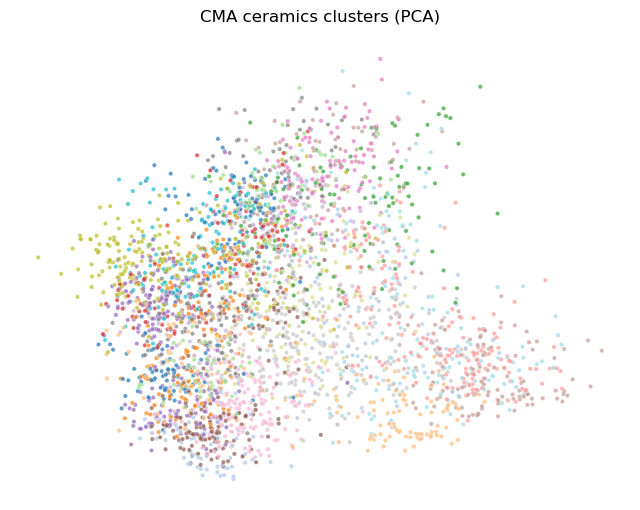

Figure saved to: cma_pca_clusters.png


In [42]:
col.cluster_images(k=40)
col.plot_pca()

In [72]:
import re, unicodedata

def add_country_and_region(col,
                           csv_path="cma_ceramics.csv",
                           region_map=None):

    # id-to-country -> col._feat_df["country","region"]

    if region_map is None:
        region_map = {
            "China": "East Asia", "Japan": "East Asia", "Korea": "East Asia",
            "Iran": "Middle East", "Iraq": "Middle East",
            "Thailand": "Southeast Asia", "Vietnam": "Southeast Asia",
            "England": "Europe", "France": "Europe",
            "Germany": "Europe", "Italy": "Europe", "Netherlands": "Europe",
            "Russia": "Europe", "Belgium": "Europe",
            "USA": "North America", "America": "North America",
        }

    meta = pd.read_csv(csv_path, low_memory=False)
    meta["id_int"] = pd.to_numeric(meta["id"], errors="coerce")
    meta = meta.dropna(subset=["id_int"])
    
    def parse_country(c):

        if pd.isna(c): 
            return "Unknown"
        txt = str(c).strip("[]'\" ")
        first = txt.split(",")[0].strip()
        return first.title() # England / France / China …
    
    meta["country"] = meta["culture"].apply(parse_country)
    
    # id → country
    id2country = dict(zip(meta["id_int"].astype(int), meta["country"]))
    
    # _feat_df
    col._feat_df["country"] = (
        col._feat_df.index
          .astype(int)
          .map(id2country)
          .fillna("Unknown")
    )

    col._feat_df["region"] = (
        col._feat_df["country"]
          .replace({"United States": "USA"})
          .map(region_map)
          .fillna("Other")
    )

    print("✅ country / region")
    print(col._feat_df[["country", "region"]].head())

add_country_and_region(col, "cma_ceramics.csv")

✅ country / region
        country     region
169872  England     Europe
140238    China  East Asia
128190     Peru      Other
123947    China  East Asia
140204    China  East Asia


In [81]:
from pathlib import Path

def generate_pca_plot(
    col,
    k: int = 40,
    save_path: str | Path = "cma_pca_clusters_ver2.png",
    dpi: int = 300,
    cmap_name: str = "tab20",
    alpha: float = 0.7,
    s: int = 25,
):

    if not hasattr(col, "_feat_df"):
        raise RuntimeError("Run extract_img_features first")
    df = col._feat_df

    if "cluster" not in df.columns:
        warnings.warn("Cannot find cluster", RuntimeWarning)
        X = df.iloc[:, :512].values.astype("float32")
        km = KMeans(
            n_clusters=k,
            random_state=42,
            n_init=10,
            algorithm="lloyd",
        ).fit(X)
        df["cluster"] = km.labels_

    if not {"pc1", "pc2"}.issubset(df.columns):
        X = df.iloc[:, :512].values.astype("float32")
        xy = PCA(n_components=2, random_state=42).fit_transform(X)
        df["pc1"], df["pc2"] = xy[:, 0], xy[:, 1]

    if "region" not in df.columns:
        df["region"] = "Unknown"
        warnings.warn("Cannot find region", RuntimeWarning)

    
    regions = sorted(df["region"].unique())
    markers = ["o", "s", "^", "D", "X", "P", "*"]
    region_marker = {r: markers[i % len(markers)] for i, r in enumerate(regions)}

    k_unique = int(df["cluster"].nunique())
    cmap = plt.get_cmap(cmap_name, k_unique)
    colors = cmap(np.linspace(0, 1, k_unique))

    fig, ax = plt.subplots(figsize=(10, 8))
    for region in regions:
        sub = df[df["region"] == region]
        ax.scatter(
            sub["pc1"], sub["pc2"],
            c=colors[sub["cluster"]],
            marker=region_marker[region],
            alpha=alpha,
            s=s,
            edgecolor="w", linewidth=0.3,
            label=region,
        )

    centroids = df.groupby("cluster")[["pc1", "pc2"]].mean()
    ax.scatter(
        centroids["pc1"], centroids["pc2"],
        marker="o", s=180, facecolors="none",
        edgecolors="k", linewidths=1.5, zorder=5,
    )
    for cid, (x, y) in centroids.iterrows():
        ax.text(x, y, str(cid), fontsize=8, weight="bold",
                ha="center", va="center",
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7),
                zorder=6)

    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title("CMA Ceramics – PCA clusters", pad=12)
    ax.axis("off")
    ax.legend(title="Region", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()

    # save
    save_path = Path(save_path)
    save_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(save_path, dpi=dpi, bbox_inches="tight")
    plt.show()
    plt.close(fig)

    print(f"[{_dt.now():%H:%M:%S}] Figure saved to: {save_path.resolve()}")


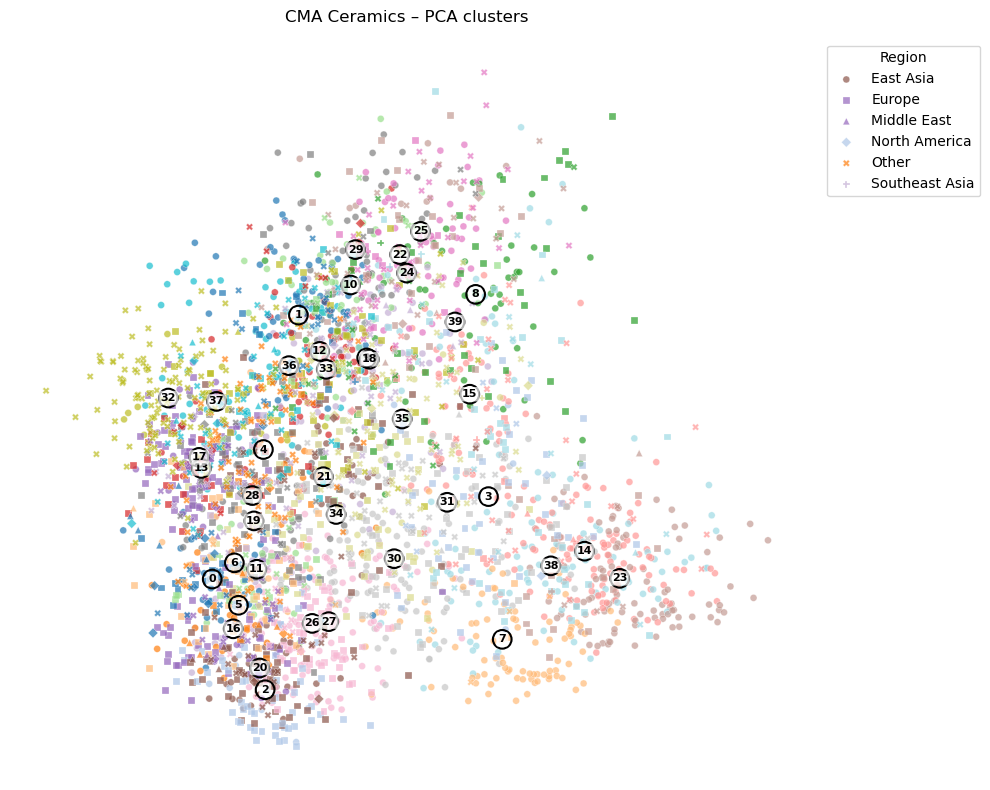

[09:25:34] Figure saved to: /Users/yufeiguo/Downloads/cma_pca_by_region.png


In [83]:
generate_pca_plot(
    col,
    k=40,
    save_path="cma_pca_by_region.png",
    dpi=300)